<a href="https://colab.research.google.com/github/R3AlL3nGz3i/RoadSegmentation/blob/main/roadExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [ ]:
%cd /content/drive/MyDrive/kaggle/


/content/drive/MyDrive/kaggle


In [ ]:
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

100% 3.79G/3.79G [03:03<00:00, 21.5MB/s]
100% 3.79G/3.79G [03:03<00:00, 22.2MB/s]


In [ ]:
!unzip '/content/drive/MyDrive/kaggle/deepglobe-road-extraction-dataset.zip' -d '/content/drive/MyDrive/kaggle/deepglobe_road'

In [ ]:
import sys
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

trainDF = {'img': [], 'mask':[] }

def LoadData(frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []

    for names in imgNames:
        names = names.split('_')[0] 
        if names not in maskNames:
            maskNames.append(names) 

    imgAdd = imgPath + "/"
    maskAdd = maskPath + "/"

    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAdd + maskNames[i] + '_sat.jpg')
            mask = plt.imread(maskAdd + maskNames[i] + '_mask.png')
        except:
            continue

        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask,(shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0])
    
    return frameObj


    

In [ ]:
def conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first convo
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
     kernel_initializer = 'he_normal',padding = 'same')(inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)


    #second convo
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
     kernel_initializer = 'he_normal',padding = 'same')(x)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x

In [ ]:
def myUnet(inputImage, numFilters  = 64, dropouts = 0.1 , doBatchNorm = True):
    # defining encoder Path
    c1 = conv2dBlock(inputImage, numFilters * 1, kernelSize= 3, doBatchNorm= doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropouts)(p1)

    c2 = conv2dBlock(p1, numFilters * 2, kernelSize= 3, doBatchNorm= doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropouts)(p2)

    c3 = conv2dBlock(p2, numFilters * 4, kernelSize= 3, doBatchNorm= doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropouts)(p3)

    c4 = conv2dBlock(p3, numFilters * 8, kernelSize= 3, doBatchNorm= doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(dropouts)(p4)
    
    c5 = conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    #decoder
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3,3),strides= (2,2), padding= 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropouts)(u6)
    c6 = conv2dBlock(u6, numFilters*8, kernelSize=3, doBatchNorm= doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3,3),strides= (2,2), padding= 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropouts)(u7)
    c7 = conv2dBlock(u7, numFilters*4, kernelSize=3, doBatchNorm= doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3,3),strides= (2,2), padding= 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropouts)(u8)
    c8 = conv2dBlock(u8, numFilters*2, kernelSize=3, doBatchNorm= doBatchNorm)
 
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3,3),strides= (2,2), padding= 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropouts)(u9)
    c9 = conv2dBlock(u9, numFilters*1, kernelSize=3, doBatchNorm= doBatchNorm)

    output = tf.keras.layers.Conv2D(1,(1,1), activation= "sigmoid")(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [ ]:
inputs = tf.keras.layers.Input((128,128,3))
unet = myUnet(inputs, dropouts= 0.07)
unet.compile(optimizer= "Adam", loss = "binary_crossentropy", metrics = ['accuracy'])

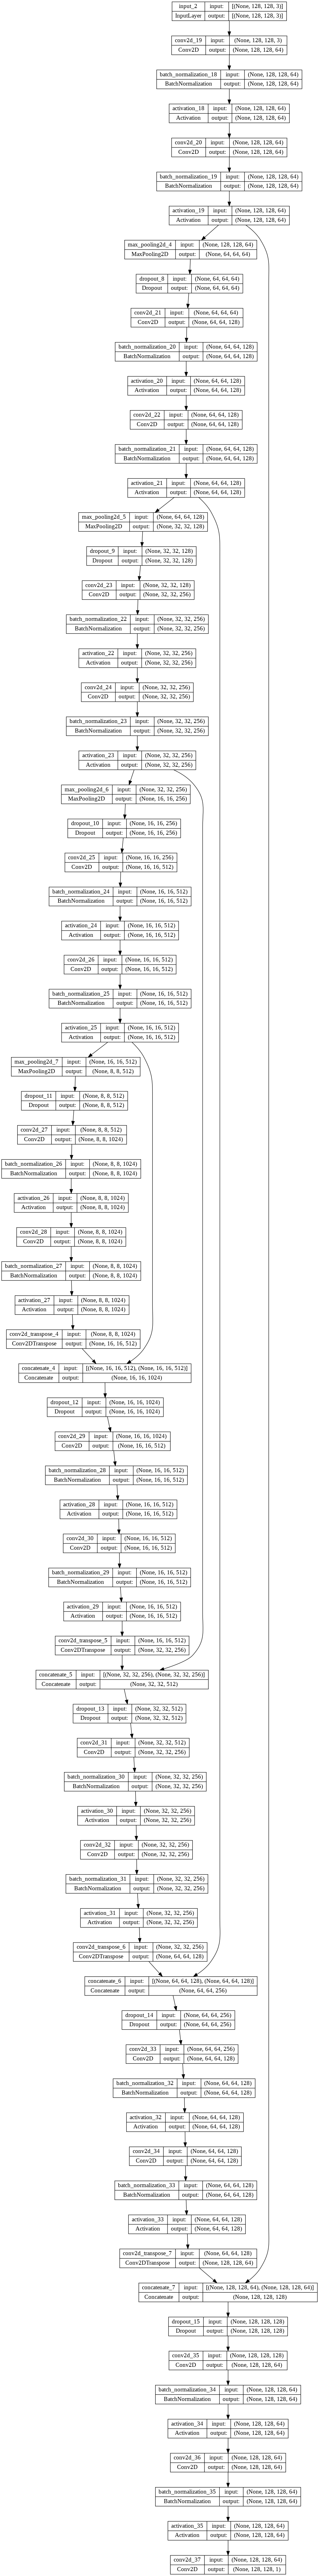

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(unet, to_file='MyDrive/kaggle/deepglobe_road/UnetArchitecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
trainDF = LoadData(trainDF, imgPath= "/content/drive/MyDrive/kaggle/deepglobe_road/train", maskPath= '/content/drive/MyDrive/kaggle/deepglobe_road/train',shape = 128)

In [ ]:
print(len(trainDF['img']))

6226


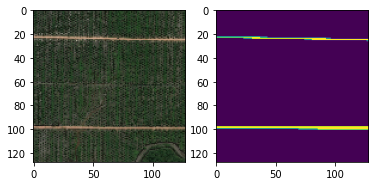

In [ ]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(trainDF['img'][1])
plt.subplot(1,2,2)
plt.imshow(trainDF['mask'][1])
plt.show()

In [ ]:
retVal = unet.fit(np.array(trainDF["img"]),np.array(trainDF["mask"]), epochs= 10, verbose= 1)

195/195 [==============================] - 101s 519ms/step - loss: 0.1049 - accuracy: 0.9591
Epoch 5/10
195/195 [==============================] - 101s 519ms/step - loss: 0.0976 - accuracy: 0.9611
Epoch 6/10
195/195 [==============================] - 101s 519ms/step - loss: 0.0915 - accuracy: 0.9628
Epoch 7/10
195/195 [==============================] - 101s 519ms/step - loss: 0.0876 - accuracy: 0.9640
Epoch 8/10
195/195 [==============================] - 102s 521ms/step - loss: 0.0833 - accuracy: 0.9654
Epoch 9/10
195/195 [==============================] - 101s 520ms/step - loss: 0.0806 - accuracy: 0.9661
Epoch 10/10
195/195 [==============================] - 101s 519ms/step - loss: 0.0783 - accuracy: 0.9669


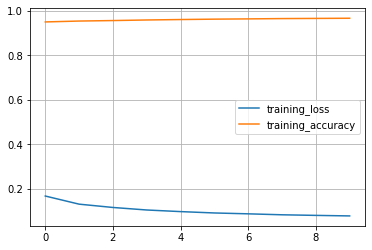

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
def predict(valMap, model, shape = 128):
  img = valMap['img'][0:16]
  mask = valMap['mask'][0:16]

  imgProc = img[0:16]
  imgProc = np.array(img)
  predictions = model.predict(imgProc)

  return predictions, imgProc, mask


In [ ]:
def plotterGraph(img, mask, groundtruth):
  plt.figure(figsize = (9,9))

  plt.subplot(1,3,1)
  plt.imshow(img)
  plt.title('aeriel image')

  plt.subplot(1,3,2)
  plt.imshow(mask)
  plt.title('predicted')

  plt.subplot(1,3,3)
  plt.imshow(groundtruth)
  plt.title('routes')

  

In [ ]:
prediction, actual, mask = predict(trainDF,unet)

1/1 [==============================] - 0s 20ms/step


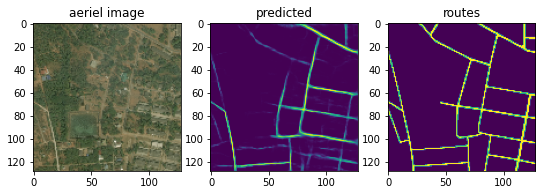

In [ ]:
plotterGraph(actual[12], prediction[12][:,:,0], mask[12])


In [ ]:
unet.save('MapSegmentationGenerator.h5')

In [ ]:
!git init

!git config — global user.email "alextankuanyu@outlook.com"
!git config — global user.name "R3AlL3nGz3i"
!git add -A

!git commit -m “first commit”


!git remote add origin https://<R3AlL3nGz3i>:<Ab1783174>@github.com/<R3AlL3nGz3i>/RoadSegmentation.git
!git push -u origin <branch>




Initialized empty Git repository in /content/drive/MyDrive/kaggle/.git/
usage: git config [<options>]

Config file location
    --global              use global config file
    --system              use system config file
    --local               use repository config file
    -f, --file <file>     use given config file
    --blob <blob-id>      read config from given blob object

Action
    --get                 get value: name [value-regex]
    --get-all             get all values: key [value-regex]
    --get-regexp          get values for regexp: name-regex [value-regex]
    --get-urlmatch        get value specific for the URL: section[.var] URL
    --replace-all         replace all matching variables: name value [value_regex]
    --add                 add a new variable: name value
    --unset               remove a variable: name [value-regex]
    --unset-all           remove all matches: name [value-regex]
    --rename-section      rename section: old-name new-name
    --remove-